In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 32,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 136MB/s]


In [8]:
# ---------------- LOSS FUNCTIONS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class AsymmetricLoss(nn.Module):
    """Asymmetric Loss for imbalanced medical data"""
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, reduction='mean'):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
        self.reduction = reduction

    def forward(self, x, y):
        xs_pos = x
        xs_neg = x
        
        # Asymmetric clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=0)
        
        # Basic CE calculation
        los_pos = y * torch.log(torch.sigmoid(xs_pos).clamp(min=self.eps))
        los_neg = (1 - y) * torch.log((1 - torch.sigmoid(xs_neg)).clamp(min=self.eps))
        
        # Asymmetric focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = torch.sigmoid(xs_pos) * y
            pt1 = xs_neg * (1 - y)  # pt1 = (1 - p) * (1 - y)
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            loss = one_sided_w * (los_pos + los_neg)
        else:
            loss = los_pos + los_neg

        if self.reduction == 'mean':
            return -loss.mean()
        elif self.reduction == 'sum':
            return -loss.sum()
        else:
            return -loss

class ZLPRLoss(nn.Module):
    """Zero-threshold Log-sum-exp Pairwise Ranking Loss for multilabel classification"""
    def __init__(self, reduction='mean', eps=1e-8):
        super(ZLPRLoss, self).__init__()
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits, targets):
        """
        Args:
            logits: Model predictions (logits) of shape (batch_size, num_classes)
            targets: Ground truth labels of shape (batch_size, num_classes)
        """
        # ZLPR Loss: L_zlpr = log(1 + <y, e^(-s)>) + log(1 + <(1-y), e^s>)
        # where y is multi-hot label, s is logit vector
        
        # Positive term: log(1 + <y, e^(-s)>)
        exp_neg_logits = torch.exp(-logits)
        pos_term = torch.log(1 + torch.sum(targets * exp_neg_logits, dim=1) + self.eps)
        
        # Negative term: log(1 + <(1-y), e^s>)
        exp_logits = torch.exp(logits)
        neg_term = torch.log(1 + torch.sum((1 - targets) * exp_logits, dim=1) + self.eps)
        
        # Combine terms
        loss = pos_term + neg_term
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class CombinedLoss(nn.Module):
    """Combined Asymmetric + Focal Loss for NIH chest X-ray classification"""
    def __init__(self, focal_weight=0.3, asymmetric_weight=0.7, 
                 focal_gamma=2, asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, 
                 asymmetric_clip=0.05):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.asymmetric_weight = asymmetric_weight
        self.focal_loss = FocalLoss(gamma=focal_gamma)
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg, 
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.focal_weight * focal + self.asymmetric_weight * asymmetric

class ZLPRCombinedLoss(nn.Module):
    """Combined ZLPR + Asymmetric Loss for advanced multilabel medical classification"""
    def __init__(self, zlpr_weight=0.6, asymmetric_weight=0.4,
                 asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, asymmetric_clip=0.05):
        super(ZLPRCombinedLoss, self).__init__()
        self.zlpr_weight = zlpr_weight
        self.asymmetric_weight = asymmetric_weight
        self.zlpr_loss = ZLPRLoss()
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg,
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        zlpr = self.zlpr_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.zlpr_weight * zlpr + self.asymmetric_weight * asymmetric

In [9]:
# Using ZLPR Loss only for pure multilabel classification
criterion = ZLPRLoss(reduction='mean', eps=1e-8)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

print("Using ZLPR Loss Only")
print("- Zero-threshold Log-sum-exp Pairwise Ranking Loss")
print("- Handles label dependencies & pairwise ranking")
print("- Pure multilabel classification approach")
print("- Mathematical elegance without hyperparameter tuning")

Using ZLPR Loss Only
- Zero-threshold Log-sum-exp Pairwise Ranking Loss
- Handles label dependencies & pairwise ranking
- Pure multilabel classification approach
- Mathematical elegance without hyperparameter tuning


In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7808 | F1: 0.3739
[Validate] Cardiomegaly AUC: 0.8696 | F1: 0.3024
[Validate] Consolidation AUC: 0.7855 | F1: 0.2127
[Validate] Edema AUC: 0.8876 | F1: 0.2857
[Validate] Effusion AUC: 0.8673 | F1: 0.5249
[Validate] Emphysema AUC: 0.8973 | F1: 0.3981
[Validate] Fibrosis AUC: 0.7901 | F1: 0.1523
[Validate] Hernia AUC: 0.8959 | F1: 0.2051
[Validate] Infiltration AUC: 0.6902 | F1: 0.3978
[Validate] Mass AUC: 0.7851 | F1: 0.3558
[Validate] Nodule AUC: 0.7381 | F1: 0.3062
[Validate] Pleural_Thickening AUC: 0.7420 | F1: 0.1755
[Validate] Pneumonia AUC: 0.7608 | F1: 0.1012
[Validate] Pneumothorax AUC: 0.8521 | F1: 0.4566
[Validate] Avg AUC: 0.8102, Avg F1: 0.3034
Training Loss: 1.7586
Validation Loss: 1.7038
Validation AUC: 0.8102
Validation F1: 0.3034
✓ NEW BEST MODEL! Saved at models/best_model_20250916-193110.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7777 | F1: 0.3631
[Validate] Cardiomegaly AUC: 0.8983 | F1: 0.3200
[Validate] Consolidation AUC: 0.7780 | F1: 0.2126
[Validate] Edema AUC: 0.9151 | F1: 0.3178
[Validate] Effusion AUC: 0.8824 | F1: 0.5560
[Validate] Emphysema AUC: 0.9205 | F1: 0.4634
[Validate] Fibrosis AUC: 0.7886 | F1: 0.1766
[Validate] Hernia AUC: 0.9557 | F1: 0.5143
[Validate] Infiltration AUC: 0.6963 | F1: 0.3939
[Validate] Mass AUC: 0.8141 | F1: 0.3967
[Validate] Nodule AUC: 0.7539 | F1: 0.3195
[Validate] Pleural_Thickening AUC: 0.7515 | F1: 0.1921
[Validate] Pneumonia AUC: 0.7747 | F1: 0.0965
[Validate] Pneumothorax AUC: 0.8505 | F1: 0.4113
[Validate] Avg AUC: 0.8255, Avg F1: 0.3381
Training Loss: 1.6925
Validation Loss: 1.6700
Validation AUC: 0.8255
Validation F1: 0.3381
✓ NEW BEST MODEL! Saved at models/best_model_20250916-195730.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040><function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
             ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7918 | F1: 0.3630
[Validate] Cardiomegaly AUC: 0.8720 | F1: 0.2895
[Validate] Consolidation AUC: 0.7917 | F1: 0.2286
[Validate] Edema AUC: 0.9167 | F1: 0.3030
[Validate] Effusion AUC: 0.8886 | F1: 0.5648
[Validate] Emphysema AUC: 0.9335 | F1: 0.4950
[Validate] Fibrosis AUC: 0.7991 | F1: 0.1784
[Validate] Hernia AUC: 0.9567 | F1: 0.5161
[Validate] Infiltration AUC: 0.6985 | F1: 0.4015
[Validate] Mass AUC: 0.8160 | F1: 0.3595
[Validate] Nodule AUC: 0.7661 | F1: 0.3222
[Validate] Pleural_Thickening AUC: 0.7615 | F1: 0.1676
[Validate] Pneumonia AUC: 0.7895 | F1: 0.0997
[Validate] Pneumothorax AUC: 0.8659 | F1: 0.4335
[Validate] Avg AUC: 0.8319, Avg F1: 0.3373
Training Loss: 1.6722
Validation Loss: 1.6529
Validation AUC: 0.8319
Validation F1: 0.3373
✓ NEW BEST MODEL! Saved at models/best_model_20250916-202337.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8040 | F1: 0.3807
[Validate] Cardiomegaly AUC: 0.9039 | F1: 0.4052
[Validate] Consolidation AUC: 0.7953 | F1: 0.2280
[Validate] Edema AUC: 0.9191 | F1: 0.3376
[Validate] Effusion AUC: 0.8890 | F1: 0.5649
[Validate] Emphysema AUC: 0.9373 | F1: 0.5000
[Validate] Fibrosis AUC: 0.8162 | F1: 0.2000
[Validate] Hernia AUC: 0.9624 | F1: 0.5143
[Validate] Infiltration AUC: 0.7099 | F1: 0.4079
[Validate] Mass AUC: 0.8348 | F1: 0.4212
[Validate] Nodule AUC: 0.7689 | F1: 0.3326
[Validate] Pleural_Thickening AUC: 0.7665 | F1: 0.1967
[Validate] Pneumonia AUC: 0.8000 | F1: 0.1012
[Validate] Pneumothorax AUC: 0.8582 | F1: 0.4488
[Validate] Avg AUC: 0.8404, Avg F1: 0.3599
Training Loss: 1.6539
Validation Loss: 1.6280
Validation AUC: 0.8404
Validation F1: 0.3599
✓ NEW BEST MODEL! Saved at models/best_model_20250916-204950.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040><function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
             ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8128 | F1: 0.4160
[Validate] Cardiomegaly AUC: 0.9011 | F1: 0.3571
[Validate] Consolidation AUC: 0.7992 | F1: 0.2355
[Validate] Edema AUC: 0.9162 | F1: 0.3312
[Validate] Effusion AUC: 0.8913 | F1: 0.5794
[Validate] Emphysema AUC: 0.9357 | F1: 0.4909
[Validate] Fibrosis AUC: 0.8187 | F1: 0.1781
[Validate] Hernia AUC: 0.9737 | F1: 0.7059
[Validate] Infiltration AUC: 0.7019 | F1: 0.4059
[Validate] Mass AUC: 0.8250 | F1: 0.3870
[Validate] Nodule AUC: 0.7810 | F1: 0.3396
[Validate] Pleural_Thickening AUC: 0.7765 | F1: 0.1974
[Validate] Pneumonia AUC: 0.8020 | F1: 0.1027
[Validate] Pneumothorax AUC: 0.8632 | F1: 0.4791
[Validate] Avg AUC: 0.8427, Avg F1: 0.3718
Training Loss: 1.6421
Validation Loss: 1.6367
Validation AUC: 0.8427
Validation F1: 0.3718
✓ NEW BEST MODEL! Saved at models/best_model_20250916-211559.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
            ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8122 | F1: 0.3993
[Validate] Cardiomegaly AUC: 0.8908 | F1: 0.3535
[Validate] Consolidation AUC: 0.7897 | F1: 0.2267
[Validate] Edema AUC: 0.9180 | F1: 0.3463
[Validate] Effusion AUC: 0.8919 | F1: 0.5725
[Validate] Emphysema AUC: 0.9357 | F1: 0.4894
[Validate] Fibrosis AUC: 0.8032 | F1: 0.2000
[Validate] Hernia AUC: 0.9743 | F1: 0.7059
[Validate] Infiltration AUC: 0.7008 | F1: 0.3968
[Validate] Mass AUC: 0.8327 | F1: 0.4264
[Validate] Nodule AUC: 0.7854 | F1: 0.3451
[Validate] Pleural_Thickening AUC: 0.7768 | F1: 0.1951
[Validate] Pneumonia AUC: 0.8008 | F1: 0.0915
[Validate] Pneumothorax AUC: 0.8662 | F1: 0.4675
[Validate] Avg AUC: 0.8413, Avg F1: 0.3726
Training Loss: 1.6325
Validation Loss: 1.6338
Validation AUC: 0.8413
Validation F1: 0.3726
No improvement. Patience: 1/5

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8174 | F1: 0.4102
[Validate] Cardiomegaly AUC: 0.9126 | F1: 0.3737
[Validate] Consolidation AUC: 0.7982 | F1: 0.2363
[Validate] Edema AUC: 0.9169 | F1: 0.3425
[Validate] Effusion AUC: 0.8926 | F1: 0.5843
[Validate] Emphysema AUC: 0.9416 | F1: 0.4904
[Validate] Fibrosis AUC: 0.8242 | F1: 0.2175
[Validate] Hernia AUC: 0.9624 | F1: 0.7647
[Validate] Infiltration AUC: 0.7134 | F1: 0.4117
[Validate] Mass AUC: 0.8395 | F1: 0.4177
[Validate] Nodule AUC: 0.7905 | F1: 0.3543
[Validate] Pleural_Thickening AUC: 0.7796 | F1: 0.1964
[Validate] Pneumonia AUC: 0.8139 | F1: 0.1060
[Validate] Pneumothorax AUC: 0.8749 | F1: 0.4863
[Validate] Avg AUC: 0.8484, Avg F1: 0.3851
Training Loss: 1.5950
Validation Loss: 1.6052
Validation AUC: 0.8484
Validation F1: 0.3851
✓ NEW BEST MODEL! Saved at models/best_model_20250916-220804.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8183 | F1: 0.4098
[Validate] Cardiomegaly AUC: 0.9171 | F1: 0.3849
[Validate] Consolidation AUC: 0.7977 | F1: 0.2396
[Validate] Edema AUC: 0.9152 | F1: 0.3300
[Validate] Effusion AUC: 0.8946 | F1: 0.5836
[Validate] Emphysema AUC: 0.9424 | F1: 0.5015
[Validate] Fibrosis AUC: 0.8266 | F1: 0.2156
[Validate] Hernia AUC: 0.9613 | F1: 0.7429
[Validate] Infiltration AUC: 0.7142 | F1: 0.4126
[Validate] Mass AUC: 0.8395 | F1: 0.4114
[Validate] Nodule AUC: 0.7898 | F1: 0.3490
[Validate] Pleural_Thickening AUC: 0.7788 | F1: 0.2065
[Validate] Pneumonia AUC: 0.8167 | F1: 0.1103
[Validate] Pneumothorax AUC: 0.8743 | F1: 0.4770
[Validate] Avg AUC: 0.8490, Avg F1: 0.3839
Training Loss: 1.5840
Validation Loss: 1.6034
Validation AUC: 0.8490
Validation F1: 0.3839
✓ NEW BEST MODEL! Saved at models/best_model_20250916-223413.pth

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8192 | F1: 0.4139
[Validate] Cardiomegaly AUC: 0.9098 | F1: 0.3730
[Validate] Consolidation AUC: 0.7977 | F1: 0.2318
[Validate] Edema AUC: 0.9170 | F1: 0.3462
[Validate] Effusion AUC: 0.8941 | F1: 0.5851
[Validate] Emphysema AUC: 0.9422 | F1: 0.4945
[Validate] Fibrosis AUC: 0.8291 | F1: 0.2222
[Validate] Hernia AUC: 0.9680 | F1: 0.7500
[Validate] Infiltration AUC: 0.7141 | F1: 0.4110
[Validate] Mass AUC: 0.8401 | F1: 0.4196
[Validate] Nodule AUC: 0.7910 | F1: 0.3468
[Validate] Pleural_Thickening AUC: 0.7735 | F1: 0.2126
[Validate] Pneumonia AUC: 0.8131 | F1: 0.0961
[Validate] Pneumothorax AUC: 0.8740 | F1: 0.4687
[Validate] Avg AUC: 0.8488, Avg F1: 0.3837
Training Loss: 1.5792
Validation Loss: 1.6064
Validation AUC: 0.8488
Validation F1: 0.3837
No improvement. Patience: 1/5

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8190 | F1: 0.4222
[Validate] Cardiomegaly AUC: 0.9087 | F1: 0.3662
[Validate] Consolidation AUC: 0.7989 | F1: 0.2349
[Validate] Edema AUC: 0.9149 | F1: 0.3272
[Validate] Effusion AUC: 0.8937 | F1: 0.5801
[Validate] Emphysema AUC: 0.9429 | F1: 0.4933
[Validate] Fibrosis AUC: 0.8337 | F1: 0.2373
[Validate] Hernia AUC: 0.9677 | F1: 0.7500
[Validate] Infiltration AUC: 0.7122 | F1: 0.4105
[Validate] Mass AUC: 0.8403 | F1: 0.4099
[Validate] Nodule AUC: 0.7890 | F1: 0.3519
[Validate] Pleural_Thickening AUC: 0.7748 | F1: 0.2057
[Validate] Pneumonia AUC: 0.8179 | F1: 0.0983
[Validate] Pneumothorax AUC: 0.8730 | F1: 0.4644
[Validate] Avg AUC: 0.8491, Avg F1: 0.3823
Training Loss: 1.5766
Validation Loss: 1.6022
Validation AUC: 0.8491
Validation F1: 0.3823
✓ NEW BEST MODEL! Saved at models/best_model_20250916-232721.pth

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8212 | F1: 0.4237
[Validate] Cardiomegaly AUC: 0.9136 | F1: 0.3682
[Validate] Consolidation AUC: 0.8011 | F1: 0.2385
[Validate] Edema AUC: 0.9168 | F1: 0.3345
[Validate] Effusion AUC: 0.8951 | F1: 0.5831
[Validate] Emphysema AUC: 0.9422 | F1: 0.4917
[Validate] Fibrosis AUC: 0.8291 | F1: 0.2350
[Validate] Hernia AUC: 0.9661 | F1: 0.7647
[Validate] Infiltration AUC: 0.7135 | F1: 0.4118
[Validate] Mass AUC: 0.8438 | F1: 0.4288
[Validate] Nodule AUC: 0.7897 | F1: 0.3636
[Validate] Pleural_Thickening AUC: 0.7730 | F1: 0.2205
[Validate] Pneumonia AUC: 0.8172 | F1: 0.1012
[Validate] Pneumothorax AUC: 0.8756 | F1: 0.4738
[Validate] Avg AUC: 0.8499, Avg F1: 0.3885
Training Loss: 1.5717
Validation Loss: 1.5978
Validation AUC: 0.8499
Validation F1: 0.3885
✓ NEW BEST MODEL! Saved at models/best_model_20250916-235409.pth

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8249 | F1: 0.4265
[Validate] Cardiomegaly AUC: 0.9115 | F1: 0.3861
[Validate] Consolidation AUC: 0.8008 | F1: 0.2439
[Validate] Edema AUC: 0.9161 | F1: 0.3451
[Validate] Effusion AUC: 0.8965 | F1: 0.5916
[Validate] Emphysema AUC: 0.9425 | F1: 0.4930
[Validate] Fibrosis AUC: 0.8343 | F1: 0.2344
[Validate] Hernia AUC: 0.9668 | F1: 0.7500
[Validate] Infiltration AUC: 0.7140 | F1: 0.4132
[Validate] Mass AUC: 0.8408 | F1: 0.4259
[Validate] Nodule AUC: 0.7899 | F1: 0.3516
[Validate] Pleural_Thickening AUC: 0.7772 | F1: 0.2118
[Validate] Pneumonia AUC: 0.8096 | F1: 0.0963
[Validate] Pneumothorax AUC: 0.8744 | F1: 0.4854
[Validate] Avg AUC: 0.8499, Avg F1: 0.3896
Training Loss: 1.5690
Validation Loss: 1.5986
Validation AUC: 0.8499
Validation F1: 0.3896
✓ NEW BEST MODEL! Saved at models/best_model_20250917-002132.pth

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8265 | F1: 0.4251
[Validate] Cardiomegaly AUC: 0.9168 | F1: 0.3710
[Validate] Consolidation AUC: 0.8015 | F1: 0.2396
[Validate] Edema AUC: 0.9156 | F1: 0.3364
[Validate] Effusion AUC: 0.8968 | F1: 0.5890
[Validate] Emphysema AUC: 0.9421 | F1: 0.4862
[Validate] Fibrosis AUC: 0.8367 | F1: 0.2249
[Validate] Hernia AUC: 0.9675 | F1: 0.7368
[Validate] Infiltration AUC: 0.7159 | F1: 0.4104
[Validate] Mass AUC: 0.8412 | F1: 0.4196
[Validate] Nodule AUC: 0.7858 | F1: 0.3469
[Validate] Pleural_Thickening AUC: 0.7764 | F1: 0.2228
[Validate] Pneumonia AUC: 0.8076 | F1: 0.0920
[Validate] Pneumothorax AUC: 0.8721 | F1: 0.4689
[Validate] Avg AUC: 0.8502, Avg F1: 0.3835
Training Loss: 1.5645
Validation Loss: 1.5963
Validation AUC: 0.8502
Validation F1: 0.3835
✓ NEW BEST MODEL! Saved at models/best_model_20250917-004812.pth

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040><function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive():Exception ignored in:  
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>  
  Traceback (most recent call last):
     File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8248 | F1: 0.4233
[Validate] Cardiomegaly AUC: 0.9142 | F1: 0.3846
[Validate] Consolidation AUC: 0.8000 | F1: 0.2371
[Validate] Edema AUC: 0.9150 | F1: 0.3404
[Validate] Effusion AUC: 0.8956 | F1: 0.5867
[Validate] Emphysema AUC: 0.9450 | F1: 0.5015
[Validate] Fibrosis AUC: 0.8386 | F1: 0.2274
[Validate] Hernia AUC: 0.9595 | F1: 0.7273
[Validate] Infiltration AUC: 0.7181 | F1: 0.4125
[Validate] Mass AUC: 0.8440 | F1: 0.4319
[Validate] Nodule AUC: 0.7863 | F1: 0.3520
[Validate] Pleural_Thickening AUC: 0.7752 | F1: 0.2149
[Validate] Pneumonia AUC: 0.8057 | F1: 0.0948
[Validate] Pneumothorax AUC: 0.8728 | F1: 0.4621
[Validate] Avg AUC: 0.8496, Avg F1: 0.3855
Training Loss: 1.5627
Validation Loss: 1.5987
Validation AUC: 0.8496
Validation F1: 0.3855
No improvement. Patience: 1/5

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8239 | F1: 0.4251
[Validate] Cardiomegaly AUC: 0.9097 | F1: 0.3774
[Validate] Consolidation AUC: 0.7971 | F1: 0.2303
[Validate] Edema AUC: 0.9156 | F1: 0.3458
[Validate] Effusion AUC: 0.8940 | F1: 0.5820
[Validate] Emphysema AUC: 0.9430 | F1: 0.5029
[Validate] Fibrosis AUC: 0.8310 | F1: 0.2083
[Validate] Hernia AUC: 0.9557 | F1: 0.7097
[Validate] Infiltration AUC: 0.7146 | F1: 0.4093
[Validate] Mass AUC: 0.8363 | F1: 0.4188
[Validate] Nodule AUC: 0.7868 | F1: 0.3535
[Validate] Pleural_Thickening AUC: 0.7701 | F1: 0.2228
[Validate] Pneumonia AUC: 0.8046 | F1: 0.1013
[Validate] Pneumothorax AUC: 0.8728 | F1: 0.4650
[Validate] Avg AUC: 0.8468, Avg F1: 0.3823
Training Loss: 1.5595
Validation Loss: 1.6027
Validation AUC: 0.8468
Validation F1: 0.3823
No improvement. Patience: 2/5

Epoch 16/25
----------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8249 | F1: 0.4217
[Validate] Cardiomegaly AUC: 0.9115 | F1: 0.3793
[Validate] Consolidation AUC: 0.7988 | F1: 0.2327
[Validate] Edema AUC: 0.9161 | F1: 0.3429
[Validate] Effusion AUC: 0.8951 | F1: 0.5871
[Validate] Emphysema AUC: 0.9441 | F1: 0.4957
[Validate] Fibrosis AUC: 0.8333 | F1: 0.2157
[Validate] Hernia AUC: 0.9562 | F1: 0.7273
[Validate] Infiltration AUC: 0.7144 | F1: 0.4103
[Validate] Mass AUC: 0.8392 | F1: 0.4246
[Validate] Nodule AUC: 0.7905 | F1: 0.3424
[Validate] Pleural_Thickening AUC: 0.7724 | F1: 0.2181
[Validate] Pneumonia AUC: 0.8022 | F1: 0.0979
[Validate] Pneumothorax AUC: 0.8721 | F1: 0.4667
[Validate] Avg AUC: 0.8479, Avg F1: 0.3830
Training Loss: 1.5534
Validation Loss: 1.6028
Validation AUC: 0.8479
Validation F1: 0.3830
No improvement. Patience: 3/5

Epoch 17/25
----------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040><function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():Exception ignored in: 
if w.is_alive(): Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040>   
Traceback (most recent call last):
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4c72f84040

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8252 | F1: 0.4225
[Validate] Cardiomegaly AUC: 0.9099 | F1: 0.3860
[Validate] Consolidation AUC: 0.7977 | F1: 0.2301
[Validate] Edema AUC: 0.9153 | F1: 0.3333
[Validate] Effusion AUC: 0.8942 | F1: 0.5809
[Validate] Emphysema AUC: 0.9452 | F1: 0.4985
[Validate] Fibrosis AUC: 0.8337 | F1: 0.2132
[Validate] Hernia AUC: 0.9587 | F1: 0.7500
[Validate] Infiltration AUC: 0.7130 | F1: 0.4127
[Validate] Mass AUC: 0.8392 | F1: 0.4236
[Validate] Nodule AUC: 0.7891 | F1: 0.3461
[Validate] Pleural_Thickening AUC: 0.7724 | F1: 0.2227
[Validate] Pneumonia AUC: 0.8007 | F1: 0.1028
[Validate] Pneumothorax AUC: 0.8717 | F1: 0.4615
[Validate] Avg AUC: 0.8476, Avg F1: 0.3846
Training Loss: 1.5527
Validation Loss: 1.6027
Validation AUC: 0.8476
Validation F1: 0.3846
No improvement. Patience: 4/5

Epoch 18/25
----------------------------------------


Epoch 18/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8255 | F1: 0.4218
[Validate] Cardiomegaly AUC: 0.9079 | F1: 0.3767
[Validate] Consolidation AUC: 0.7974 | F1: 0.2311
[Validate] Edema AUC: 0.9148 | F1: 0.3312
[Validate] Effusion AUC: 0.8943 | F1: 0.5852
[Validate] Emphysema AUC: 0.9447 | F1: 0.5074
[Validate] Fibrosis AUC: 0.8332 | F1: 0.2121
[Validate] Hernia AUC: 0.9543 | F1: 0.7500
[Validate] Infiltration AUC: 0.7146 | F1: 0.4124
[Validate] Mass AUC: 0.8365 | F1: 0.4215
[Validate] Nodule AUC: 0.7896 | F1: 0.3496
[Validate] Pleural_Thickening AUC: 0.7715 | F1: 0.2222
[Validate] Pneumonia AUC: 0.8051 | F1: 0.0981
[Validate] Pneumothorax AUC: 0.8725 | F1: 0.4626
[Validate] Avg AUC: 0.8473, Avg F1: 0.3844
Training Loss: 1.5522
Validation Loss: 1.6028
Validation AUC: 0.8473
Validation F1: 0.3844
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


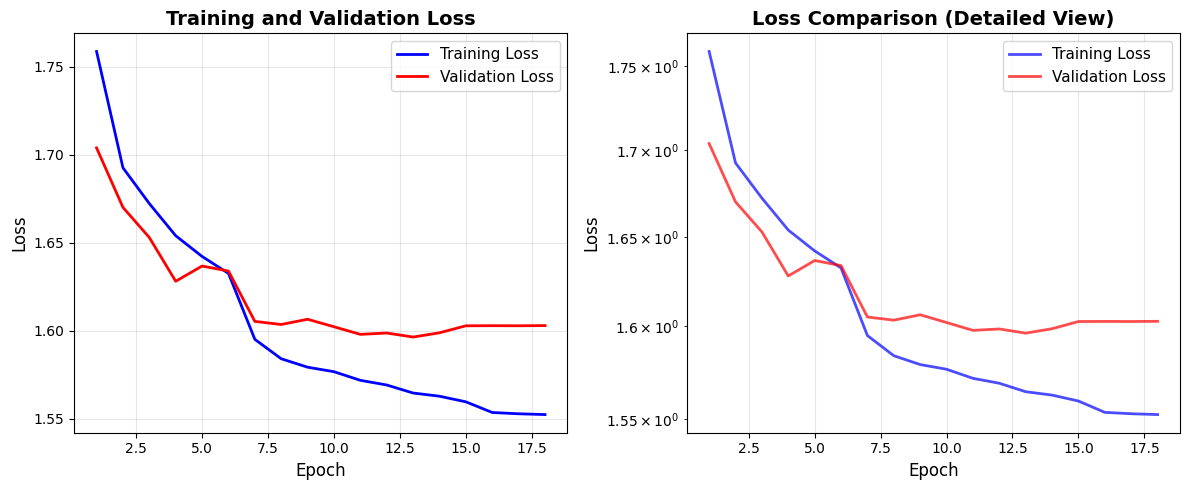


===== TRAINING SUMMARY =====
Final Training Loss: 1.5522
Final Validation Loss: 1.6028
Best Validation AUC: 0.8502
Total Epochs Trained: 18
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8153 | F1: 0.4076
[Test] Cardiomegaly AUC: 0.9244 | F1: 0.5038
[Test] Consolidation AUC: 0.7793 | F1: 0.2356
[Test] Edema AUC: 0.8928 | F1: 0.2478
[Test] Effusion AUC: 0.9024 | F1: 0.6110
[Test] Emphysema AUC: 0.9614 | F1: 0.5139
[Test] Fibrosis AUC: 0.8507 | F1: 0.1562
[Test] Hernia AUC: 0.9960 | F1: 0.7368
[Test] Infiltration AUC: 0.7070 | F1: 0.4025
[Test] Mass AUC: 0.8969 | F1: 0.4556
[Test] Nodule AUC: 0.7705 | F1: 0.3136
[Test] Pleural_Thickening AUC: 0.8009 | F1: 0.2561
[Test] Pneumonia AUC: 0.6955 | F1: 0.0778
[Test] Pneumothorax AUC: 0.8776 | F1: 0.3481
[Test] Avg AUC: 0.8479, Avg F1: 0.3762


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 1.6263
Avg AUROC : 0.8479
Avg F1    : 0.3762

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8153     0.4076     0.2167    
Cardiomegaly         0.9244     0.5038     0.3010    
Consolidation        0.7793     0.2356     0.1434    
Edema                0.8928     0.2478     0.1480    
Effusion             0.9024     0.6110     0.2869    
Emphysema            0.9614     0.5139     0.1149    
Fibrosis             0.8507     0.1562     0.3303    
Hernia               0.9960     0.7368     0.0971    
Infiltration         0.7070     0.4025     0.1838    
Mass                 0.8969     0.4556     0.2990    
Nodule               0.7705     0.3136     0.2020    
Pleural_Thickening   0.8009     0.2561     0.1327    
Pneumonia            0.6955     0.0778     0.0707    
Pneumothorax         0.8776     0.3481     0.1926    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

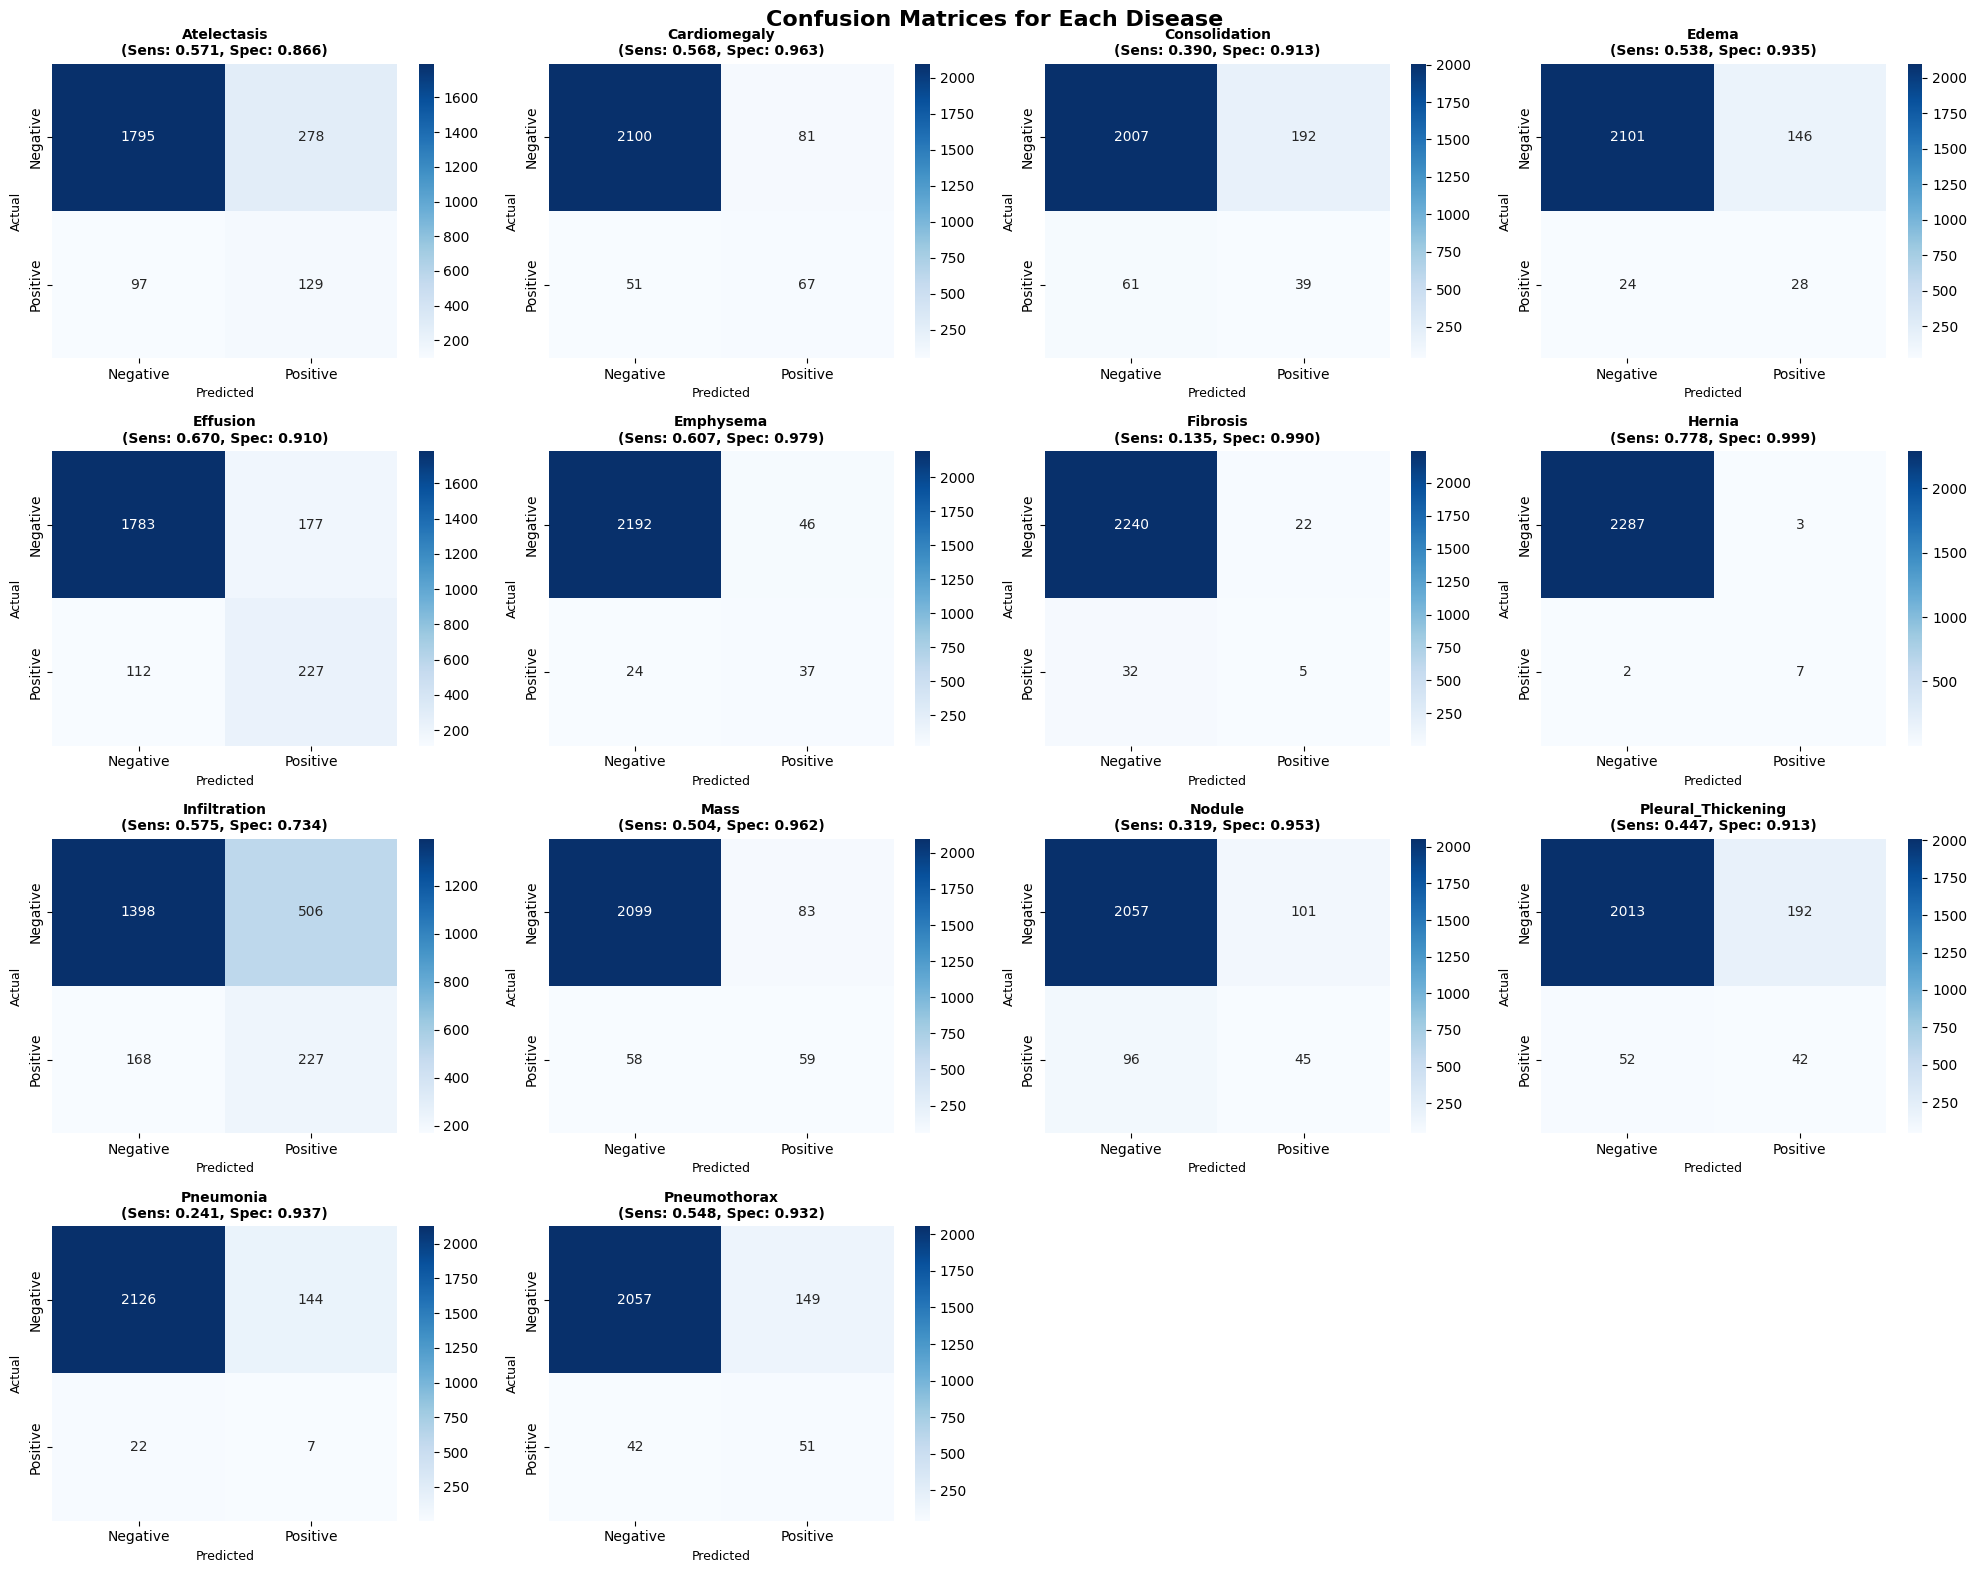

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          129    1795   278    97     0.571    0.866    0.317    0.949   
Cardiomegaly         67     2100   81     51     0.568    0.963    0.453    0.976   
Consolidation        39     2007   192    61     0.390    0.913    0.169    0.971   
Edema                28     2101   146    24     0.538    0.935    0.161    0.989   
Effusion             227    1783   177    112    0.670    0.910    0.562    0.941   
Emphysema            37     2192   46     24     0.607    0.979    0.446    0.989   
Fibrosis             5      2240   22     32     0.135    0.990    0.185    0.986   
Hernia               7      2287   3      2      0.778    0.999    0.700    0.999   
Infiltration         227    1398   506    168    0.575    0.734    0.310    0.893   
Ma